# Parallel programming: shared-memory approaches

**Python for HPC course**

Max Planck Computing and Data Facility, Garching

### Outline

* What is parallel computing?
* Shared vs. distributed memory
* Multiprocessing

## Why parallel computing?


* Over decades: faster computers because of increase in frequency
* Problem: heat production ($\sim f^3$) $\to$ CPU frequency constant since ~2004
* Since then: increase in program execution speed by exploiting parallelism

![CPU frequency over time](fig/frequency_history.svg)

### Categorization of parallel computing

* Two main categories of parallelism relevant to HPC (Flynn's Taxonomy)
    * Single Instruction Multiple Data (SIMD)  
      $\to$ vector units (e.g. vector instructions)
    * Multiple Instruction Multiple Data (MIMD)  
      $\to$ multi-CPUs (e.g. concurrent threads/processes)
* Literature: M. Quinn, *Parallel programming in C with MPI and OpenMP*

### Exploiting parallelism

$\to$ How-to decompose your computational problem into sub-problems that can be solved in parallel?

* Task parallelism
    * Compute independent tasks in parallel
    * Usually dependency graph necessary
    * Example: compute different parts of a Hamiltonian in parallel
* Data parallelism
    * Distribute data (e.g. accross processors or nodes) and operate on data in parallel
    * Examples:
        * same processing pipeline for different data
        * solve PDEs on a grid with domain decomposition

### Hierarchy of parallelism in HPC hardware

1. Multiple compute nodes ("individual computers") in a HPC cluster
2. Per compute node: several (~2) multi-core CPU-sockets
3. Per CPU-socket: multiple physical cores (~20 - 128)
4. Per physical core: Vector instructions, Pipelining, SMT
    * Vector instructions (e.g. SSE, AVX, AVX512) do several floating point operations per cycle
    * Pipelining reduces latencies by instruction-level parallism to keep processor units busy

### Hierarchy of parallelism in HPC hardware

#### How does Python fit in here?

* Level 1: distributed memory, communication via messages over a network
    * `mpi4py`
* Levels 2 and 3: shared memory
    * `mpi4py`
    * `multiprocessing`
    * threading, e.g. OpenMP, Cython, Numba, NumPy using an optimized math library like MKL
* Level 4: rely on libraries (NumPy $\to$ MKL) or compilers (C/F, Cython, Numba) to do it right!

## Performance analysis
* How much speed-up is achievable by using several processors?
* Speedup: $\psi = T_\mathsf{sequential}/T_\mathsf{parallel}$
* Efficiency: $\epsilon = \psi/p$  (with $p$ number of processors)
* Parallel algorithm usually contains
    * Sequential computations
    * Parallel computations
    * Parallel overhead
    
$\to$ efficiency is less than 1!

### Amdahl's law
* Maximum speed-up depending on fraction of sequential computations $f$
$$ \psi \le \frac{1}{f + (1-f)/p}  \le \frac{1}{f}$$
* Example:
    * 10% sequential operations $\to \ f=0.1\ \to\ \psi \le 10$
    * Do not use more than 10 processors if the code has 10% of sequential operation!

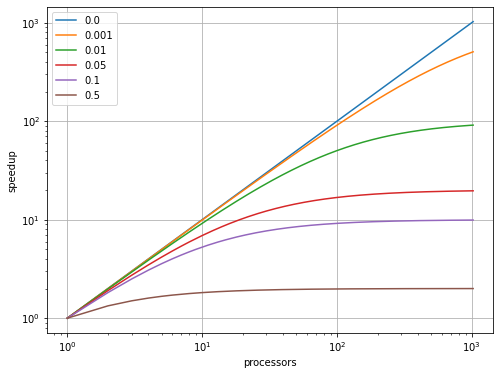

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
processors = np.linspace(1,1024,1024)
serial_fraction = [0.0, 0.001, 0.01, 0.05, 0.1, 0.5]
plt.figure(figsize=(8,6))
plt.grid(True)
for f in serial_fraction:
    plt.loglog(processors, 1/(f + (1-f)/processors), label=f)
plt.legend()
plt.xlabel('processors')
l = plt.ylabel('speedup')

### Scaling analysis

* In Practice: Determine by experiments up to which point your code scales
* Scaling analysis: *strong scaling*
    * Run code for same **relevant** setup on 1, 2, 4, 8, 16, ... cores
    * Compute speed-up
    * Compare to ideal scaling in log-log plot (speed-up vs cores)
    * Problems where scaling curve deviates strongly from ideal scaling
    * Efficiency (speed-up/ideal speed-up) should be above 70-80%
* Scaling analysis also possible for different parts of the code (individual timings!)
* For deeper analysis of code: fit theoretical expectation to measured timings
* In general: identify hotspots and analyze code repeatedly when working on parallelization

## Programming models

* Shared memory: all processes/threads can access the same memory $\to$ only on one node
    * Threads: **OpenMP** for C and Fortran
    * Processes: `multiprocessing` for Python
* Distributed memory: each process has its own memory $\to$ may cover several nodes
    * **MPI**: message passing interface
    * Communication handled by programmer
* Hybrid programming possible: MPI+OpenMP

## Parallelism in Python

* Python-internal threads (not useful for HPC!)
* multithreaded modules or libraries (e.g. Numba, NumPy with MKL, etc.)
* Processes (shared memory)
    * `multiprocessing`, comparably easy to use
    * restricted to one node
* MPI or parallel frameworks (distributed memory)
    * `mpi4py`
    * more complex
    * can be used over a cluster

### Processes vs Threads
* Process
    * relatively expensive to create/switch,  
      creating a new subprocess ('forking') copies the process memory
    * own resources: memory, address space, environment, file handles, sockets, ...
    * address spaces are isolated $\to$ explicit communication needed between processes
* Thread
    * relatively cheap to create/switch
    * enable independent threads of execution within the same process
    * share most resources (address space, memory, ...)

### Threads in Python

* Python supports threads, **however** due to
* cPython's global interpreter lock (GIL)
    * only one thread may execute Python bytecode at a time
    * no parallelization of computations possible with threads (although I/O or GUI might benefit)
* new in python 3.13: [GIL can be made optional](https://peps.python.org/pep-0703/), but not yet mature

$\to$ **Python threads are not useful for HPC**  
$\to$ **use several Python processes instead**

### Python Multiprocessing

* Idea: Start several processes on one node to distribute the workload over CPUs
* Use processes instead of threads $\to$ sidestep the global interpreter lock
* `multiprocessing` module, part of the Python standard library
* Most important use case: Data parallelism with the `Pool` class
* Caveat: size of "work units" needs to be large enough compared to overhead of process creation
* Explicit interprocess communication possible via Queues
* https://docs.python.org/3/library/multiprocessing.html

### The `multiprocessing.Pool` class

* Create a pool of worker processes that get different chunks of the workload
    * Fork the processes when starting the work
    * Join the processes when workload is finished
    * Obtain the result on the primary process
* Continue with primary process

#### `multiprocessing.Pool` easiest to use with the `map` function

In [5]:
# Reminder: Python's map builtin applies a function to an iterator
def f(x):
    return x*x

result = map(f, range(6))

print(tuple(result))

(0, 1, 4, 9, 16, 25)


In [7]:
# multiprocessing.Pool provides a parallel map
from multiprocessing import Pool

with Pool(3) as p:
    result = p.map(f, range(6))

print(result)

[0, 1, 4, 9, 16, 25]


### `multiprocessing.Pool` $-$ it is really faster!

In [19]:
from multiprocessing import Pool
import time

def g(x):
    time.sleep(0.5)
    return x*x

start = time.time()
result = [g(x) for x in range(6)]
print("sequential time: {:f}".format(time.time() - start))

start = time.time()
with Pool(3) as p:
    result = p.map(g, range(6))
print("pool time: {:f}".format(time.time() - start))

sequential time: 3.004981
pool time: 1.051848


###  `multiprocessing.Pool` combined with threading
* Pool can be combined with a threaded library, e.g. numpy calls via MKL, numba with auto-parallelization
* Product of number of processes for Pool and number of threads should equal the number of cores of the CPU
* Set variables `OMP_NUM_THREADS`, `NUMBA_NUM_THREADS` to control number of threads

### Asynchronous parallel computing via `concurrent.futures`

* `concurrent.futures` enables the *asynchronous* execution of tasks
* useful with `ProcessPoolExecutor()` which actually builds upon `multiprocessing`
* `map` offloads tasks to the worker Pool and returns an iterator that is order-preserving
* 'futures' are tasks that are offloaded via `submit()`, `as_completed` provides an iterator in completion-order
* https://docs.python.org/3/library/concurrent.futures.html

In [39]:
import time, random
from concurrent.futures import ProcessPoolExecutor, as_completed

def g(x):
    print(f"worker g({x})")
    time.sleep(random.random())
    return x*x

print("--- map ---")
with ProcessPoolExecutor(max_workers=2) as ppe:
    sq = ppe.map(g, range(4))
    print("main process, continuing in the meantime")
    for n in sq:
        print(n)
    print(f"main process, all done")

print("--- futures ---")
with ProcessPoolExecutor(max_workers=2) as ppe:
    sq = {ppe.submit(g, n): n for n in range(4)}
    print("main process, continuing in the meantime")
    for n in as_completed(sq):
        print(f"g({sq[n]}) = {n.result()}")
    print(f"main process, all done")

--- map ---
worker g(0)
worker g(1)
main process, continuing in the meantime
worker g(2)
worker g(3)
0
1
4
9
main process, all done
--- futures ---
worker g(0)
worker g(1)
worker g(2)
main process, continuing in the meantime
g(0) = 0
worker g(3)
g(2) = 4
g(3) = 9
g(1) = 1
main process, all done


### Summary: Shared-memory parallelization in Python

* Python threads are not useful for HPC
* Processes can be used with `multiprocessing` module
* Simple cases of data parallelism $\to$ `Pool` class with fork-join model
* Creating processes is expensive $\to$ work packages for each process should be large enough!
* `concurrent.futures` provides asynchronous tasks

### Outlook: multiprocessing exercises

* Parallel image processing
* Monte Carlo $\pi$ computation